In [67]:
import pandas as pd 
import numpy as np 
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn import metrics 
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.preprocessing import PolynomialFeatures, StandardScaler
from sklearn import preprocessing
from sklearn.feature_selection import RFE
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import VarianceThreshold
from sklearn.feature_selection import RFE, RFECV, SelectKBest, chi2
import cmath
import random

sns.set()

from rdkit.Chem.Draw import IPythonConsole
from rdkit import Chem
from rdkit.Chem import Draw

import pubchempy as pcp

import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor as vif

from sklearn.exceptions import DataConversionWarning
import warnings
warnings.filterwarnings(action='ignore', category=DataConversionWarning)
warnings.filterwarnings(action='ignore', category=DeprecationWarning)
warnings.filterwarnings(action='ignore', category=FutureWarning)

%matplotlib inline

file = "QSARData.csv"

df = pd.read_csv(file)

print("original shape:", df.shape)
print(df.dtypes)

# ## Check for missing data

def missing_data(data):
    missing_df = data.isnull().sum(axis=0).reset_index()
    missing_df.columns = ['variable', 'missing values']
    missing_df['coverage (%)']=(data.shape[0]-missing_df['missing values'])/data.shape[0]*100
    missing_df.sort_values('coverage (%)').reset_index(drop = True)
    print(missing_df.loc[missing_df['coverage (%)'] < 90.0])
    #print(missing_df.loc[missing_df['coverage (%)'] < 100.0])
    less_cov = missing_df.loc[missing_df['coverage (%)'] < 90.0]
    return missing_df, less_cov
    

missing_df, low_cov_data = missing_data(df)
low_cols = list(low_cov_data['variable'])
data = df.drop(columns = low_cols, axis=1)
print("shape after dropping null columns: ", data.shape)

original shape: (179, 321)
Unnamed: 0            int64
depVar              float64
XLogP               float64
MW                  float64
LipinskiFailures      int64
nRotB                 int64
MLogP               float64
nAtomLAC              int64
nAtomP                int64
nAtomLC               int64
nB                    int64
nBase                 int64
nAtom                 int64
nAromBond             int64
naAromAtom            int64
ALogP               float64
ALogp2              float64
AMR                 float64
nAcid                 int64
nSmallRings           int64
nAromRings            int64
nRingBlocks           int64
nAromBlocks           int64
nRings3               int64
nRings4               int64
nRings5               int64
nRings6               int64
nRings7               int64
nRings8               int64
nRings9               int64
                     ...   
GRAV.6              float64
PPSA.1.1            float64
PPSA.2.1            float64
PPSA.3.1            f

In [14]:
## Visualise the artemisinin structure

a = pcp.Compound.from_cid(68827)

print("Molecular formula: ", a.molecular_formula)
print("Isomeric SMILES: ", a.isomeric_smiles)
print("Canonical SMILES: ", a.canonical_smiles)
print("XLogP: ", a.xlogp)

m = Chem.MolFromSmiles(a.isomeric_smiles)
m

Molecular formula:  C15H22O5
Isomeric SMILES:  C[C@@H]1CC[C@H]2[C@H](C(=O)O[C@H]3[C@@]24[C@H]1CC[C@](O3)(OO4)C)C
Canonical SMILES:  CC1CCC2C(C(=O)OC3C24C1CCC(O3)(OO4)C)C
XLogP:  2.8


### Target variable analysis

The target variable is the log of the relative activity measure. This measure is described as follows:

log RA = log(IC50 artemisinin / IC50 analogue) x log (MW analogue / MW artemisinin)

The below analysis indicates that the majority of the analogues produce log RA values between -1 and 1. However, there are also about 20 compounds that exhibit the same log RA value of -4, even though they are structurally diverse. This is important and is likely to affect the models accuracy, given the inputs features are molecular descriptors. 

count    179.000000
mean      -0.611173
std        1.568864
min       -4.000000
25%       -0.925000
50%       -0.040000
75%        0.375000
max        1.470000
Name: depVar, dtype: float64


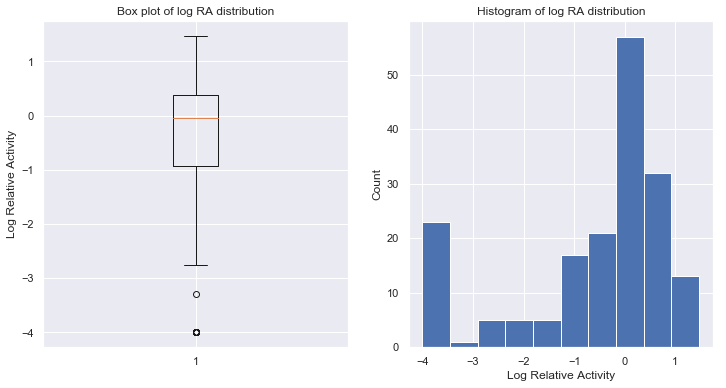

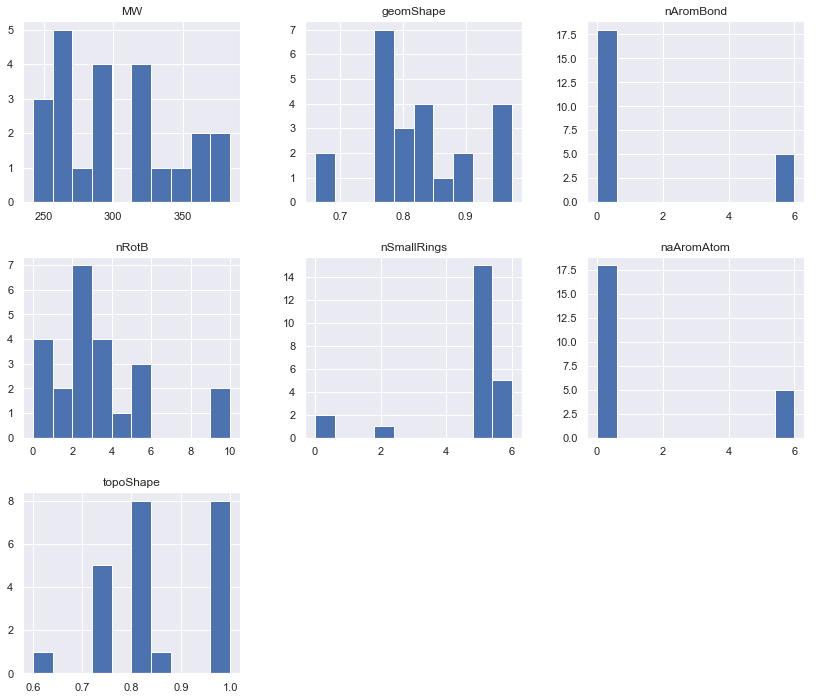

In [32]:
## Target variable analysis
X = data.drop('depVar', axis=1)
y = data['depVar']

fig, ax = plt.subplots(1, 2, figsize=(12,6))
print(y.describe())
ax[0].set_title("Box plot of log RA distribution")
ax[0].boxplot(data['depVar'])
ax[0].set_xlabel("")
ax[0].set_ylabel("Log Relative Activity")

ax[1].set_title("Histogram of log RA distribution")
ax[1].hist(y)
ax[1].set_xlabel("Log Relative Activity")
ax[1].set_ylabel("Count")
plt.show()

## Molecules with the same log RA value 

mol = data.loc[data['depVar'] == -4]
mol.columns.tolist()

# Geometric features 

geo = ['MW','topoShape', 'geomShape', 'nSmallRings', 'nRotB', 'nAromBond', 'naAromAtom']

mol_geo = mol[geo]
#plt.hist(mol_geo, stacked=True)
mol_geo.hist(label="Feature analysis for compounds with the same log RA value", figsize=(14,12))
plt.show()

In [75]:
## Variance threshold feature selection

# Get feature variables that have zero variance for all samples

print("original shape: ", data.shape)
sel = VarianceThreshold(threshold=(0))
sel.fit_transform(data)

# Keep only columns that have a greater variance than 0.0 for all data samples 

variance_selected = data[data.columns[sel.get_support(indices=True)]]
print("processed shape: ", variance_selected.shape)
variance_selected.head(4)



original shape:  (179, 317)
processed shape:  (179, 250)


Unnamed: 0  depVar  XLogP          MW  LipinskiFailures  nRotB  MLogP  \
0           1    0.00  3.039  282.146724                 0      0   2.56   
1           2    0.45  5.687  386.209324                 1      5   3.44   
2           3    0.79  2.746  268.131074                 0      0   2.45   
3           4   -0.17  3.039  282.146724                 0      0   2.56   

   nAtomLAC  nAtomP  nAtomLC    ...       WNSA.2.1   WNSA.3.1    RPCG.1  \
0         0       3        0    ...     -92.140284 -12.390258  0.168942   
1         4       6        4    ...    -269.317410 -20.082190  0.132376   
2         0       3        0    ...     -98.096786 -14.346520  0.172827   
3         0       3        0    ...     -91.947207 -12.397583  0.168942   

     RNCG.1    RPCS.1    RNCS.1      THSA.1      TPSA.1    RHSA.1    RPSA.1  
0  0.198795  0.185955  2.032461  385.676043   81.019556  0.826397  0.173603  
1  0.157303  0.349696  0.963157  600.235859   82.855988  0.878704  0.121296  
2  0.205562  0.586998  2.523145  371.146537  101.389037  0.785436  0.214564  
3  0.198795  0.185955  2.032461  385.298659   81.190429  0.825954  0.174046  

[4 rows x 250 columns]

### Feature analysis



['nRings7', 'MDEO.22', 'khs.ssO', 'WPOL', 'WTPT.3', 'WTPT.4', 'ATSm4', 'GRAV.6', 'GRAV.5', 'ATSp4']


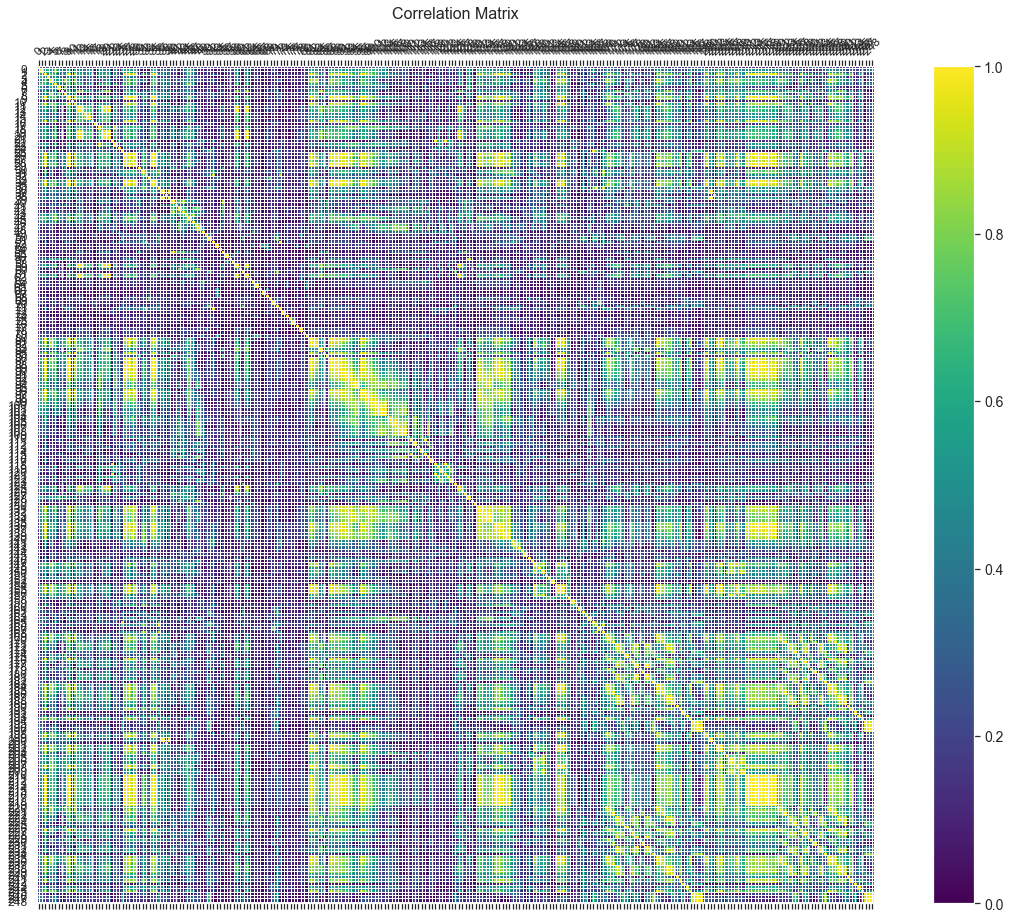

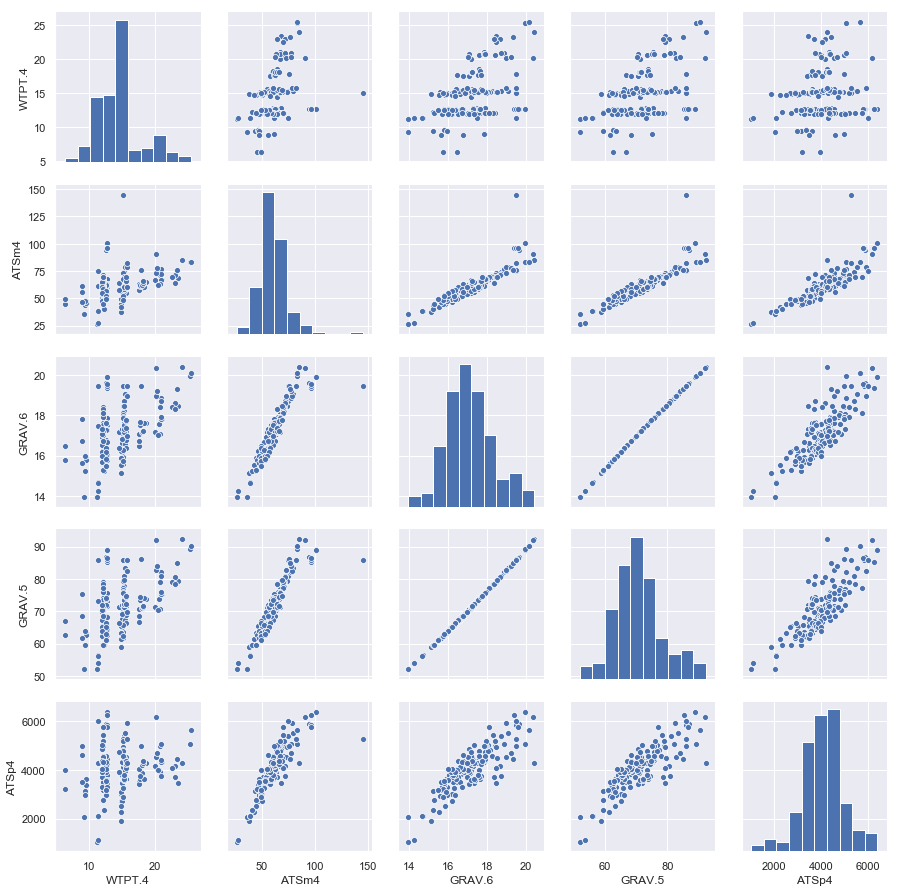

In [116]:
## Feature Analysis

X = variance_selected.drop('depVar', axis=1)
y = variance_selected['depVar']

## Correlation - spearmans rank 
corr_matrix = X.corr(method='spearman').abs()
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(np.bool))

f = plt.figure(figsize=(19, 15))
plt.matshow(corr_matrix, fignum=f.number,cmap='viridis')
plt.xticks(range(corr_matrix.shape[1]), list(range(corr_matrix.shape[1])), fontsize=12, rotation=45)
plt.yticks(range(corr_matrix.shape[1]), list(range(corr_matrix.shape[1])), fontsize=12)
cb = plt.colorbar()
cb.ax.tick_params(labelsize=14)
plt.axis('image')
plt.title('Correlation Matrix', fontsize=16)

## Correlation with y-variable

corr_yvar = X.corrwith(y, axis=0, drop=False).sort_values(ascending=False).head(10)
features = corr_yvar.index.values.tolist()
print(features)

# Feature distributions of top correlated variables
sns.pairplot(variance_selected[features[:5]])
plt.suptitle('Top 10 variables with highest pearson correlation to log RA',
             size = 20)
sns.pairplot(variance_selected[features[5:]])
plt.show()

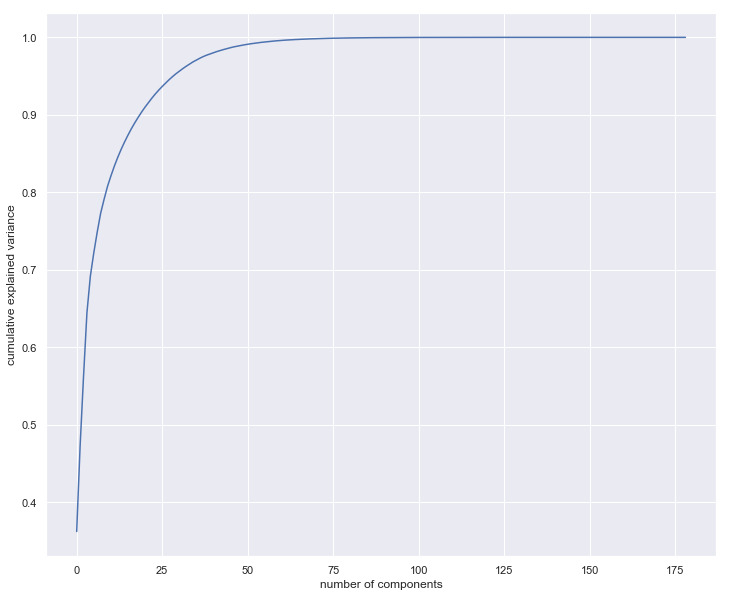

X shape (179, 249)
Projected shape (179, 4)
4 components pca explained variance: [90.75482839 27.53938583 22.51244672 20.66616186]
0.95 variance pca explained variance: [90.75482839 27.53938583 22.51244672 20.66616186 11.79803873  7.50762782
  6.68931032  6.07330131  4.49010229  4.17683325  3.40400583  3.13568117
  2.86742143  2.60058141  2.385295    2.21491965  2.08691034  1.91273361
  1.78326799  1.69470108  1.58495075  1.47191915  1.43675587  1.33421285
  1.24451763  1.1594325   1.10514701  1.06761501  0.9892684   0.93400469
  0.84774443  0.81097819  0.76852857  0.72259792  0.69409805  0.60834412
  0.57444327  0.53948895  0.45955968  0.40196171  0.39379617]
0.95 variance pca number components: 41


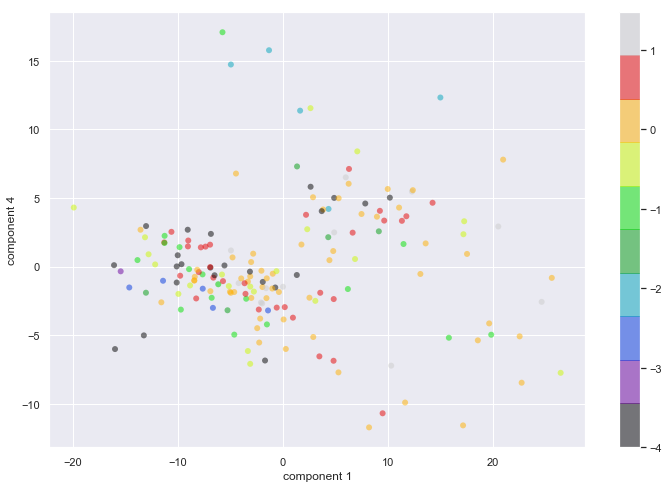

In [134]:
## PCA analysis

from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

X_scaled = StandardScaler().fit_transform(X.values)

pca = PCA().fit(X_scaled)
plt.figure(figsize=(12,10))
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('number of components')
plt.ylabel('cumulative explained variance')
#plt.xlim(0,4)
plt.show()

pca_four = PCA(n_components=4)  # project from many to 4 dimensions
projected = pca_four.fit_transform(X_scaled)

pca_var = PCA(n_components=0.98, svd_solver='full')
projected_four = pca_var.fit_transform(X_scaled)

print("X shape", X.shape)
print("Projected shape", projected.shape)
print("4 components pca explained variance:", pca_four.explained_variance_)
print("0.95 variance pca explained variance:", pca_var.explained_variance_)
print("0.95 variance pca number components:", pca_var.n_components_)
#print("PCA Components: ", pca.components_)

plt.figure(figsize=(12,8))
plt.scatter(projected[:, 0], projected[:, 1],
            c=y, edgecolor='none', alpha=0.5,
            cmap=plt.cm.get_cmap('jet', 10))
plt.xlabel("component 1")
plt.ylabel("component 2")
plt.colorbar()
plt.show()

plt.figure(figsize=(12,8))
plt.scatter(projected[:, 0], projected[:, 2],
            c=y, edgecolor='none', alpha=0.5,
            cmap=plt.cm.get_cmap('jet', 10))
plt.xlabel("component 1")
plt.ylabel("component 3")
plt.colorbar()
plt.show()

plt.figure(figsize=(12,8))
plt.scatter(projected[:, 0], projected[:, 3],
            c=y, edgecolor='none', alpha=0.5,
            cmap=plt.cm.get_cmap('jet', 10))
plt.xlabel("component 1")
plt.ylabel("component 4")
plt.colorbar()
plt.show()

# fig, ax = plt.subplots(1,3, figsize=(16,8))
# ax[0].scatter(projected[:, 0], projected[:, 1],
#             c=y, edgecolor='none', alpha=0.5,
#             cmap=plt.cm.get_cmap('nipy_spectral', 10))
# ax[0].set_xlabel("component 1")
# ax[0].set_ylabel("component 2")
# ax[1].scatter(projected[:, 0], projected[:, 2],
#             c=y, edgecolor='none', alpha=0.5,
#             cmap=plt.cm.get_cmap('nipy_spectral', 10))
# ax[1].set_xlabel("component 1")
# ax[1].set_ylabel("component 3")
# ax[2].scatter(projected[:, 0], projected[:, 3],
#             c=y, edgecolor='none', alpha=0.5,
#             cmap=plt.cm.get_cmap('nipy_spectral', 10))
# ax[2].set_xlabel("component 1")
# ax[2].set_ylabel("component 4")
# plt.colorbar()
# plt.show()


# ax[1,1].scatter(projected[:, 0], projected[:, 4],
#             c=y, edgecolor='none', alpha=0.5,
#             cmap=plt.cm.get_cmap('nipy_spectral', 10))
# plt.xlabel('component 1')
# plt.ylabel('component 2')


In [6]:
## Removed highly correlated predictors

## Separate the dependent and independent variables 

original = df_high.copy()
y_var = original['depVar']
original.drop(columns = ['depVar','Unnamed: 0'], inplace = True, axis=1)

print("original shape: ", original.shape)

# Correlation matrix analysis
corr_matrix = original.corr().abs()

# Select upper triangle of correlation matrix
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(np.bool))

# Find index of feature columns with correlation greater than 0.8
to_drop = [column for column in upper.columns if any(upper[column] > 0.8)]
print("number of features with correlations over 0.8: ", len(to_drop))

# Drop columns 
dropped = original.drop(columns = to_drop, axis=1)

print("updated shape:", dropped.shape)   

dropped.head(4)

original shape:  (179, 315)
number of features with correlations over 0.8:  173
updated shape: (179, 142)


XLogP          MW  LipinskiFailures  nRotB  nAtomLAC  nAtomP  nBase  \
0  3.039  282.146724                 0      0         0       3      0   
1  5.687  386.209324                 1      5         4       6      0   
2  2.746  268.131074                 0      0         0       3      0   
3  3.039  282.146724                 0      0         0       3      0   

    ALogP  nAcid  nSmallRings    ...     WD.unity  BCUTw.1l  BCUTc.1l  \
0  0.8012      0            5    ...     1.474806    11.999 -0.314393   
1  1.3625      0            6    ...     1.307998    11.999 -0.314125   
2  0.5412      0            5    ...     1.473248    11.999 -0.314390   
3  0.8012      0            5    ...     1.474258    11.999 -0.314393   

   BCUTc.1h  BCUTp.1l      PNSA.1     PNSA.3      RPCG      RPCS      RNCS  
0  0.267195  4.745096  124.877588 -26.548908  0.168942  0.185955  2.032461  
1  0.264376  4.471269  197.510368 -29.398959  0.132376  0.349696  0.963157  
2  0.264340  4.430722  135.776837 -30.360719  0.172827  0.586998  2.523145  
3  0.267195  4.745096  124.671077 -26.576362  0.168942  0.185955  2.032461  

[4 rows x 142 columns]

In [10]:
dropped_sel.columns

Index(['XLogP', 'MW', 'LipinskiFailures', 'nRotB', 'nAtomLAC', 'nAtomP',
       'nBase', 'ALogP', 'nAcid', 'nSmallRings', 'nRings5', 'nRings7',
       'tpsaEfficiency', 'WTPT.3', 'WTPT.5', 'topoShape', 'geomShape',
       'MDEC.11', 'MDEC.12', 'MDEC.13', 'MDEC.24', 'MDEC.33', 'MDEC.34',
       'MDEC.44', 'MDEO.11', 'MDEO.12', 'MDEO.22', 'MDEN.22', 'MDEN.23',
       'khs.dCH2', 'khs.ssCH2', 'khs.dsCH', 'khs.dssC', 'khs.aaaC', 'khs.sNH2',
       'khs.ssNH', 'khs.dsN', 'khs.aaN', 'khs.sssN', 'khs.sOH', 'khs.dO',
       'khs.aaO', 'khs.sF', 'khs.dsssP', 'khs.dS', 'khs.aaS', 'khs.ddssS',
       'khs.sCl', 'khs.sBr', 'FMF', 'SC.3', 'SC.4', 'SC.6', 'SCH.6', 'C1SP2',
       'C1SP3', 'C4SP3', 'ATSc4', 'ATSc5', 'Wlambda1.unity', 'Wlambda2.unity',
       'Wnu1.unity', 'Weta1.unity', 'Weta2.unity', 'Weta3.unity', 'WD.unity',
       'BCUTw.1l', 'BCUTc.1l', 'BCUTc.1h', 'BCUTp.1l', 'PNSA.1', 'PNSA.3',
       'RPCG', 'RPCS', 'RNCS'],
      dtype='object')

In [19]:
dropped_sel['y_var'] = y_var 

dropped_sel.to_csv("qsar_processed.csv", index=False)

/Users/nathalie.willems/anaconda3/envs/rdkit-env/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.
